<a href="https://colab.research.google.com/github/Jyotika999/Image-Restoration/blob/main/Blind_Image_Deconvolution_Demonstration_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blind Image Deconvolution (BID) Demonstration

This notebook gives a demonstration of one type of Blind Image Deconvolution using the modified Davey Algorithm.

We begin with some housekeeping (Python imports)

In [ ]:
import numpy as np
import math as m

from PIL import Image, ImageFont, ImageDraw
import imageio
import os, shutil

SNAPSHOT_DIR = './snapshots'


# Initial Estimate Selection
class InitialEstimate:
    BLURRED_IMAGE = 0
    RANDOM = 1
    CONSTANT = 2


# Perform blind image deconvolution using the modified Davey et al algorithm
def bid_davey(original_img, original_psf, blurred_img, (psfWidth, psfHeight), iterations, initial=InitialEstimate.BLURRED_IMAGE, save_snapshots=False):

    snapshot_filenames = []
    if (save_snapshots) :
        if os.path.exists(SNAPSHOT_DIR):
            shutil.rmtree(SNAPSHOT_DIR)
        os.mkdir(SNAPSHOT_DIR)


    result = 0                                    # Optimal restored image

    original_img = original_img.astype(float)
    blurred_img = blurred_img.astype(float)

    supportWidth = np.shape(original_img)[1]
    supportHeight = np.shape(original_img)[0]
    channels = np.shape(original_img)[2]

    entireWidth = np.shape(blurred_img)[1]
    entireHeight = np.shape(blurred_img)[0]



    # Embed original image within and psf frame
    frame = np.zeros((entireHeight, entireWidth, channels))
    origin_x = (np.ceil((entireWidth-supportWidth)/2)+1).astype(int)
    origin_y = (np.ceil((entireHeight-supportHeight)/2)+1).astype(int)
    frame[origin_y:(origin_y+supportHeight), origin_x:(origin_x+supportWidth), 0:channels] = original_img
    original_img = frame

    frame = np.zeros((entireHeight, entireWidth, channels))
    frame[origin_y:(origin_y+supportHeight), origin_x:(origin_x+supportWidth), :] = np.dstack((original_psf, original_psf, original_psf))
    original_psf = frame


    # Storage for tracking MSE vs iteration count
    image_mse = np.zeros((iterations, 2))                 # Initialise image MSE array
    psf_mse = np.zeros((iterations, 2))                   # Initialise PSF MSE array

    min_mse = 0                                           # Minimum f(^(x,y) MSE
    min_mse_iterations = 0                                # Number of iterations to achieve minimum f(^(x,y) MSE


    ##########################
    # Set up initial conditions
    #
    # 4 options :-
    #
    #  1) Use observed (blurred) image as starting point
    #  2) Random initial estimate
    #  3) Non-zero constant as initial estimate
    #
    initial_estimate = None
    if initial == InitialEstimate.RANDOM:
        initial_estimate = np.round(255*np.random.rand(entireHeight, entireWidth, channels))

    elif initial == InitialEstimate.CONSTANT:
        initial_estimate = np.multiply(np.ones((entireHeight, entireWidth, channels)), 100)

    else:
        initial_estimate = blurred_img


    f = initial_estimate

    g = blurred_img

    ##########################

    # Message display
    print "Performing optimal deblur. Progress: [",

    # Used for progress bar display
    countMAX = np.round(iterations * 0.05) # 5% increments
    counter = 0

    h = None
    G = np.fft.fft2(g, axes=(0,1))

    for iteration in range (0, iterations):
        counter += 1
        if (counter == countMAX):
            print ".",                     # Progress bar display
            counter = 0
            if (save_snapshots):
                generateSnapshot(f, channels, iteration, SNAPSHOT_DIR, snapshot_filenames)

        F = np.fft.fft2(f, axes=(0,1))
        H = wiener(G, F)                                     # Wiener constraint
        h = np.fft.fftshift(np.fft.ifft2(H, axes=(0,1)), axes=(0,1))
        h = psfConstraint(h, (psfWidth, psfHeight), (supportWidth, supportHeight))
        H = np.fft.fft2(h, axes=(0,1))
        F = wiener(G, H)                                     # Wiener constraint
        f = np.fft.fftshift(np.fft.ifft2(F, axes=(0,1)), axes=(0,1))
        f = imageConstraint(f, (supportWidth, supportHeight))

        if (iteration == iterations - 1):
            print "] (complete)"

        # Calculate and store Mean Squared Error for iteration
        f_mse = computeMSE(f, original_img)
        h_mse = computeMSE(h, original_psf)
        image_mse[iteration, 0] = psf_mse[iteration, 0] = iteration
        image_mse[iteration, 1] = f_mse
        psf_mse[iteration, 1] = h_mse

        if (iteration == 0):
            min_mse = f_mse
            min_mse_iterations = 0
            result = f

        if (f_mse < min_mse):
            min_mse = f_mse
            min_mse_iterations = iteration
            result = f

    # end for loop


    # Prepare to return results
    result = result[origin_y:origin_y+supportHeight, origin_x:origin_x+supportWidth, 0:channels]
    for ch in range (0, channels):
        result[:, :, ch] = np.multiply(np.divide(result[:, :, ch], np.max(result[:, :, ch])), 255)
    result = np.abs(result).astype(np.uint8)

    restored_psf = h[:,:,1]
    restored_psf = np.multiply(np.divide(restored_psf, np.max(restored_psf)), 255)
    restored_psf = np.abs(restored_psf).astype(np.uint8)

    if(save_snapshots):
        images = []
        for filename in snapshot_filenames:
            images.append(imageio.imread(filename))
            imageio.mimsave(SNAPSHOT_DIR + '/snapshots.gif', images, format='GIF', duration=1)

    return (result, restored_psf, image_mse, psf_mse, min_mse, min_mse_iterations)


def psfConstraint(data, psf_dims, support):

    supportWidth = support[0]
    supportHeight = support[1]
    entireWidth = data.shape[1]
    entireHeight = data.shape[0]
    channels = data.shape[2]

    psfHeight  = psf_dims[1]
    psfWidth = psf_dims[0]

    origin_x = int(m.ceil((float(entireWidth - psfWidth) / 2) + 1))
    origin_y = int(m.ceil((float(entireHeight - psfHeight) / 2) + 1))

    # Enforce positivity and support constraints
    frame = np.zeros((entireHeight, entireWidth, channels))
    frame[origin_y-1 : origin_y+psfHeight-1, origin_x-1 : origin_x+psfWidth-1, 0:channels] = np.ones((psfHeight, psfWidth, channels))
    data = np.multiply(data, frame).clip(min=0)

    # TODO check whether whole thing should be set to zero if <0 -- or just individual real/complex parts

    return data


def imageConstraint(data, support):

    entireWidth = data.shape[1]
    entireHeight = data.shape[0]
    channels = data.shape[2]

    supportWidth = support[0]
    supportHeight = support[1]

    origin_x = int(m.ceil((float(entireWidth - supportWidth) / 2) + 1))
    origin_y = int(m.ceil((float(entireHeight - supportHeight) / 2) + 1))

    # Enforce positivity and support constraints
    frame = np.zeros((entireHeight, entireWidth, channels))
    frame[origin_y-1 : origin_y+supportHeight-1, origin_x-1 : origin_x+supportWidth-1, 0:channels] = np.ones((supportHeight, supportWidth, channels))
    data = np.multiply(data, frame).clip(min=0)

    return data



def wiener (num, den):
    beta = 0.5
    W = np.divide(np.conj(den), np.square(np.abs(den)) + np.divide(beta, np.square(np.abs(den)) ) )
    return np.multiply(W, num)


# Calculate the Mean Squared Error (MSE) between two matrices
def computeMSE(estimate, original):
    mse = 0

    # Normalise estimate
    estimate = np.multiply(np.divide(estimate, np.max(estimate)), 255)
    if (estimate.shape != original.shape):
        raise Exception('ERROR: estimate %s and original %s are not the same dimensions [computeMSE()].' % (estimate.shape, original.shape))
    else:
        mse = np.abs(np.square(np.subtract(estimate, original)).mean())

    return mse

def generateSnapshot(f, channels, iteration, SNAPSHOT_DIR, snapshot_filenames):
    for ch in range (0, channels):
        snapshot = f
        snapshot[:, :, ch] = np.multiply(np.divide(snapshot[:, :, ch], np.max(snapshot[:, :, ch])), 255)
    snapshot = np.dstack( (snapshot, 255*np.ones((snapshot.shape[0], snapshot.shape[1]))) )
    snapshot = np.abs(snapshot).astype(np.uint8)
    filename = SNAPSHOT_DIR + '/snap_' + '{:06d}'.format(iteration) + '.bmp'
    img = Image.fromarray(snapshot, mode='RGBA')
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    draw.text((10, snapshot.shape[0]-10), "Snap-" + str(iteration), font=font, fill="#fff0c0")
    snapshot_filenames.append(filename)
    img.save(filename)

In [ ]:
import imageio                                                # Image file I/O
import numpy as np                                            # Matrix support, FFT etc
import math
from scipy import signal                                      # Signal processing library
from IPython.display import Math                              # LaTex support
import matplotlib.pyplot as plot                              # Plots

# from modifiedDaveyDeblur import bid_davey, InitialEstimate    # Blind image deconvolution

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Next, import our image of choice...

Source image dimensions: (340, 550, 3)


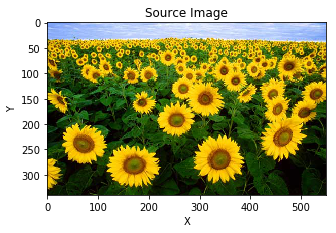

In [ ]:
image_name = '/content/gdrive/MyDrive/imagessssssss/flower.jpg'


# Load and show source image
src_img = imageio.imread(image_name)
print "Source image dimensions:", src_img.shape

plot.figure(figsize=(5,5))
plot.title('Source Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

Next, we add some 'atmospheric blurring'. This is achieved by running the source image through a circular (pillbox) filter. The larger the blur kernel, the smoother the image becomes.

<img src="img/blurring.png" width="600">

If:
* f(x,y) is our source image before blurring
* h(x,y) is the effective transfer function modelling the blurring mechanism (Point Spread Function)
* g(x,y) is our blurred image


then the blurred image is the result of the 2D-convolution of each RGB colour channel with the PSF:

In [ ]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y)')

<IPython.core.display.Math object>

Blurred image dimensions: (360, 570, 3)


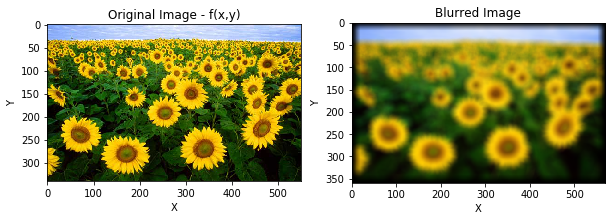

In [ ]:
# Create circular filter PSF
r = 10
y,x = np.ogrid[-r: r+1, -r: r+1]
psf = x**2+y**2 <= r**2
psf = psf.astype(float) / np.sum(psf)


blur_img = np.zeros((src_img.shape[0] + 2*r, src_img.shape[1] + 2*r, src_img.shape[2]))
print "Blurred image dimensions:", blur_img.shape

for ch in range(src_img.shape[2]):    
    blur_img[:,:,ch] = signal.convolve2d(src_img[:,:,ch], psf, mode ='full', boundary = 'fill', fillvalue = 0)

    
# Plot before and after blurring    
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

plot.subplot(1, 2, 2)
plot.title('Blurred Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(blur_img/np.max(blur_img))


Realisitically some noise is added to the system during the capture process. This manifests from things like:
-  electronic noise
-  thermal noise at the CCD camera
-  quantisation noise

We model this by using an additive unknown noise term n(x,y), with the properites of being a zero-mean Gaussian random variable.

![image.png](img/1d_gaussian.jpg)

so we now have:

In [ ]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y) + n(x,y)')

<IPython.core.display.Math object>

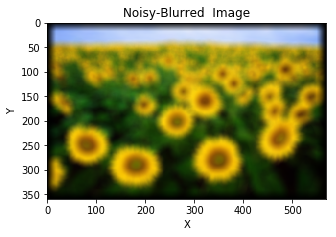

In [ ]:
# Add Gaussian noise to the observed image
mu, sigma = 0, 0.1
scale = 0.0
noise = scale * np.multiply(np.random.normal(mu, sigma, blur_img.shape), blur_img)

noisyBlur_img = np.add(blur_img, noise)
noisyBlur_img = np.round(noisyBlur_img, 0).astype(np.uint8)
#imageio.imsave( '_blurred.'.join(image_name.rsplit('.', 1)), (np.divide(noisyBlur_img, np.max(noisyBlur_img))*255).astype(np.uint8))

# Plot noisy, blurred image
plot.figure(figsize=(5,5))
plot.title('Noisy-Blurred  Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(noisyBlur_img)

We can define the signal to noise ratio (SNR) as:

In [ ]:
Math(r'SNR(dB) = 20\log_{10}  \Bigg(   \frac {A_{signal}} {A_{noise}} \Bigg)')

<IPython.core.display.Math object>

In [ ]:
Math(r'SNR (dB) = P(dB)_{signal} - P (dB)_{noise}')

<IPython.core.display.Math object>

In [ ]:
def power(image):
    return 20*np.log10( np.sqrt(np.mean(np.square(image))) )

signalPower = power(blur_img)
noisePower  = power(noise)
snr         = signalPower - noisePower
print("SNR = {0} dB".format(snr))


SNR = inf dB


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0,0.5,'Y')

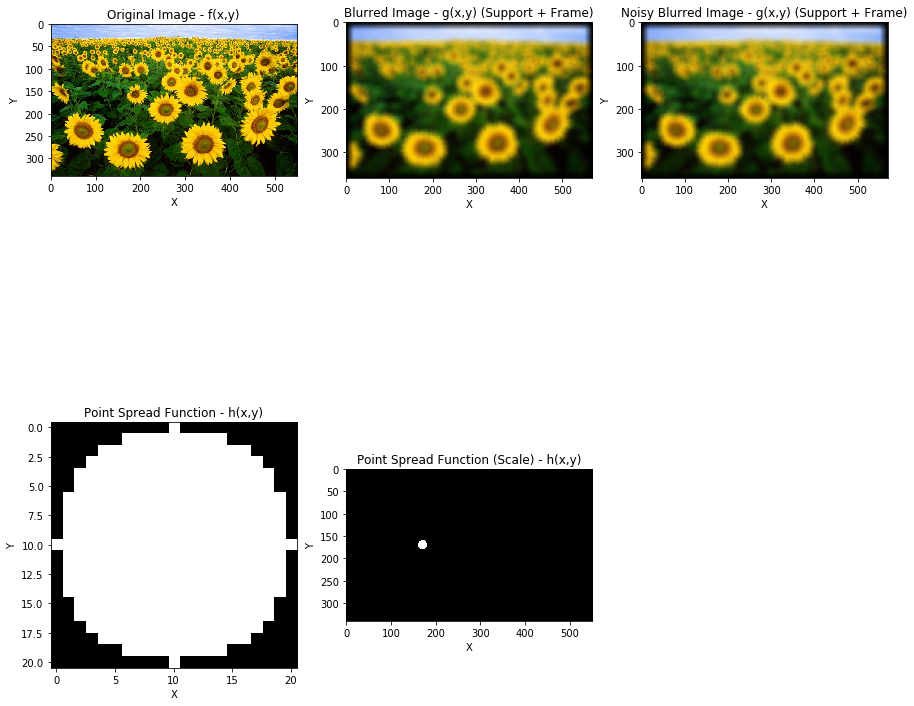

In [ ]:
 
# Plot before and after blurring    
plot.figure(figsize=(15,15))
plot.subplot(2, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 2)
plot.imshow(blur_img/np.max(blur_img))
plot.title('Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 3)
plot.imshow(noisyBlur_img)
plot.title('Noisy Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')


# Show PSF
psfplot = np.zeros((src_img.shape[0], src_img.shape[1]))
nb = psfplot.shape[0]
na = psf.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb) // 2 + math.ceil(float(na) / 2)
psfplot[lower:int(upper), lower:int(upper)] = psf

plot.subplot(2, 3, 4)
plot.imshow(psf, cmap='gray')
plot.title('Point Spread Function - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 3, 5)
plot.imshow(psfplot, cmap='gray')
plot.title('Point Spread Function (Scale) - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

Next we apply the Davey Blind image deconvolution algorithm to iteratively 'deblur' the noisy image...

<img src="img/davey_algorithm_flow.png" width="600">



Performing optimal deblur. Progress: [ . . . . . . . . . . . . . . . . . . . . ] (complete)
Results:
--------
Minimum MSE of 1105 occurs at iteration# 0.


Text(0,0.5,'MSE')

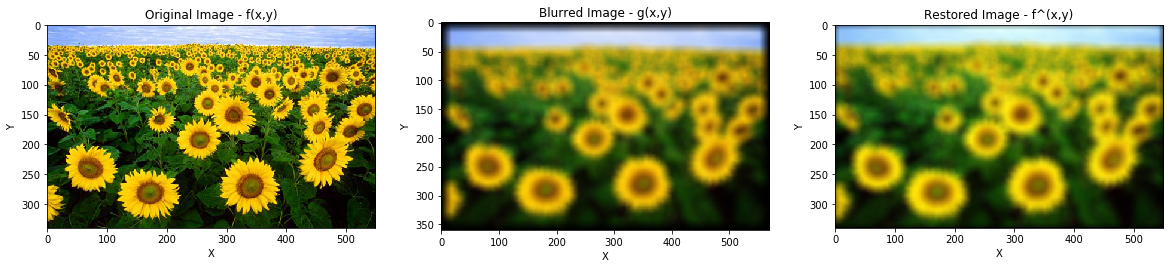

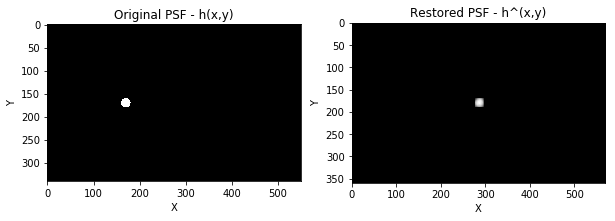

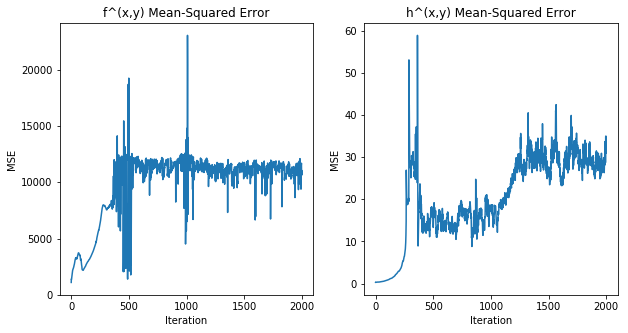

In [ ]:
# BID iterations
iterations = 2000
save_snapshots = False  # True / False

(restored_img, restored_psf, image_mse, psf_mse, mse_min, mse_min_iterations) = bid_davey(src_img, psfplot, noisyBlur_img, psf.shape, iterations, InitialEstimate.BLURRED_IMAGE, save_snapshots)

imageio.imsave( '_restored.'.join(image_name.rsplit('.', 1))  , restored_img) # Save the result



print "Results:"
print "--------"
print "Minimum MSE of %d occurs at iteration# %d." % (math.ceil(mse_min), mse_min_iterations)

# Plot recovered image
plot.figure(figsize=(20,20))
plot.subplot(1, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 2)
plot.imshow(noisyBlur_img)
plot.title('Blurred Image - g(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 3)
plot.imshow(restored_img)
plot.title('Restored Image - f^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot recovered PSF
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.imshow(psfplot, cmap='gray')
plot.title('Original PSF - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 2, 2)
plot.imshow(restored_psf, cmap='gray')
plot.title('Restored PSF - h^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot MSE
plot.figure(figsize=(10,5))
plot.subplot(1, 2, 1)
plot.plot(image_mse[:,1])
plot.title('f^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

plot.subplot(1, 2, 2)
plot.plot(psf_mse[:,1])
plot.title('h^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

